In [1]:
import os
import time
import re
import numpy as np
import math
from os import listdir
from os.path import isfile, join

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

import paramiko
import subprocess

from scipy.ndimage import imread
from scipy import ndimage
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd

from utils import read_tiff, make_dir, read_images_from_directory, smooth
#from monitor_utils import *

In [122]:
#---------------------------
#   Colors
#---------------------------

blue = (57 / 255.0, 106 / 255.0, 177 / 255.0)
red = (204/ 255.0, 37/ 255.0, 41/ 255.0 )
green = (62/ 255.0, 150/ 255.0, 81/ 255.0 )  
grey = (128/ 255.0, 133/ 255.0, 133/ 255.0 )
gold = (237/ 255.0, 218/ 255.0, 116/ 255.0 )

#---------------------------
#   Fonts
#---------------------------

title_font_size = 20
label_font_size = 16
ticks_font_size = 16



def read_flow_from_components(file_u, file_v, shape):
    u = np.fromfile(file_u, dtype='float32', sep="")
    u = u.reshape(shape)
    
    v = np.fromfile(file_v, dtype='float32', sep="")
    v = v.reshape(shape)
    
    return u,v

def read_raw_image(file_name, shape):
    img = np.fromfile(file_name, dtype='float32', sep="")
    img = img.reshape(shape)
    
    return img
    

def read_raw_files_save_as_multitiff_stack(path, file_name, shape, mask=""):
    if mask == "":
        files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    else:
        files = sorted([f for f in listdir(path) if isfile(join(path, f)) and f.find(mask) != -1])
        
    #print('Number of images to convert:', len(files))
    
    imlist = []
    for f in files:
        #im = np.array(Image.open(p + f))
        #imlist.append(Image.fromarray(m))

        np_im = read_raw_image(path + f, shape)
        imlist.append(Image.fromarray(np_im))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])

    #print('OK')


    
#----------------------------#
# Time analysis              #
#----------------------------#
def time_analysis(images, corr_images, cx, cy, rx, ry, y_pos=60, ax=None, region='all', show=False, color='k'):
    
    if  not ax:
        ax  = plt.subplot(111)

    #def avg_nonzero(a): 
    #    return np.mean(a[a > 0])

    all_shots_vel = []

    #for s in range(1):    
    for s in range(shots_num):
        # Get sequence for the shot
        seq = images[s*seq_length:(s+1)*seq_length]
        seq_corr = corr_images[s*seq_length:(s+1)*seq_length]

        mean_vel_values = []

        #for i in range(1):
        for i in range(seq_length): 

            im = seq[i][cy-ry:cy+ry,cx-rx:cx+rx]
            c = seq_corr[i][cy-ry:cy+ry,cx-rx:cx+rx]
            #print(cy-r_2, cx-r_2)

            # Filtering
            
            # 1. Put away large velocity outliers
            #filtered_amp = np.where(im < 10, im, 0)
            if filter_high:
                im = np.where(im < max_vel_in_pixels, im, 0)
            
                
            # 2. Drop velocities with low correlation values
            if filter_corr:
                filtered_corr = np.where(c > min_corr_value, 1, 0)
                im = im*filtered_corr
                #filtered_corr = 1.0
                
            # 3. Drop zero velocities from avareging
            if filter_zero:
                nonzero_values = im[im > min_vel_in_pixels]
                if len(nonzero_values) == 0:
                    im = 0.0
                else:
                    im = np.mean(nonzero_values)
            
                
            
            #amp_nonzeros_mean = np.mean(filtered_amp[filtered_amp > 0])
            if not (filter_high and filter_zero):
                im = np.mean(im)
                

            # Convert to m/s
            im = im*vel_factor
            #amp_nonzeros_mean = amp_nonzeros_mean*vel_factor

            mean_vel_values.append(im)
            #mean_vel_values.append(amp_nonzeros_mean)

        all_shots_vel.append(mean_vel_values)
        #ax.plot(mean_vel_values, linewidth=1.0, alpha=0.3)

    smooth_mask = 4
    all_shots_mean = np.mean(np.array(all_shots_vel), axis=0)
    ax.plot(smooth(all_shots_mean, smooth_mask, 'flat'), linewidth=2.0, color=color, linestyle='dashed')
    
    ax.set_title('Velocity evolution, region: ' + region, size=title_font_size)
    
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0, (0+seq_length)+1, 5)*sample_rate / 1000.0]
    x_ticks = np.arange(0, seq_length+1, 5)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_lables, fontsize = ticks_font_size)
    
    ax.set_ylabel('velocity, [m\s]', size=label_font_size)
    ax.set_xlabel('time from injection, [s]', size=label_font_size)


    overall_mean = np.mean(all_shots_mean)
    overall_std = np.std(all_shots_mean)

    #print('Overall average in region {0:.2f} m/s'.format(overall_mean))
    #print('Overall variation in region {0:.2f} m/s'.format(overall_std))
    #print('Variation in percent {0:.1f} %'.format(overall_std / overall_mean * 100))
    
    ax.text(1, y_pos, 'Mean: {0:.2f} m/s'.format(overall_mean), fontsize=14, color=color)
    ax.text(26, y_pos, 'STD: {0:.2f} m/s'.format(overall_std), fontsize=14, color=color)

    ax.set_ylim(vel_min,vel_max)
    ax.yaxis.set_tick_params(labelsize=label_font_size)
    
    if show:
        plt.show()
        
    return overall_mean, overall_std

def avg_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.mean(non_zero_vals)
    
def std_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.std(non_zero_vals)

    

def make_analysis_figure():

    #------------------------------
    # Start analysis
    #------------------------------

    print('Analysis...')
    
    width = images.shape[2]
    height = images.shape[1]
    
    print(width, height)
    
    cx = int(width / 2) 
    cy = int(height / 2)

    # Make masking
    med = np.median(images, axis=0)  
    thres = np.where(med > 5, 255.0, 0.0)
    dilated = dilation(thres, disk(6))
    mask = gaussian_filter(dilated, 3.5) 
    im_res = Image.fromarray(mask)
    im_res.save(results_path + '_mask.tif')

    # Mean velocity without any filtering
    amp_mean = np.mean(images, axis=0)
    amp_mean_unfiltered_center = np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx])
    im_res = Image.fromarray(amp_mean*vel_factor)
    im_res.save(results_path + '_amp_mean_nofilter.tif')
    
    
    amp_mean = np.mean(images, axis=0)
    print('Mean unfiltered, center:', amp_mean_unfiltered_center*vel_factor)
    
    amp_median = np.median(images, axis=0)
    print('Median unfiltered, center:', np.mean(amp_median[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
        
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    p = 0.25
    min_vel_in_pixels = (1.0 - p)*amp_mean_unfiltered_center
    max_vel_in_pixels = (1.0 + p)*amp_mean_unfiltered_center

    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    #filtered_amp = images # no filtering
    #filtered_amp = np.where(np.abs(images) < 10, images, 0) # Filter y-components
    filtered_corr = np.where(corr > min_corr_value, 1, 0)
    #filtered_corr = 1.0
    filtered_amp = filtered_amp*filtered_corr

    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    im_res = Image.fromarray(amp_filtered_mean*vel_factor)
    im_res.save(results_path + '_amp_mean_filter.tif')

    measure_name = 'Mean filtered velocity'
    measure_file = 'amp_mean_filter'

    pano = amp_filtered_mean*vel_factor

    amp_seq = images


    # Setup figure
    fig = plt.figure(1)

    fig.set_size_inches(20/2 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(2, 1, height_ratios=[1.3,1])

    #-------------------------------------------
    # Figure 1: Velocity maps
    #-------------------------------------------

    # Setup figure
    ax0 = plt.subplot(gs[0,:])

    imx = ax0.imshow(pano, vmin=vel_min, vmax=vel_max, cmap='inferno')
    ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
    ax0.set_xlabel('distance, [mm]', size=label_font_size)
    ax0.set_ylabel('distance, [mm]', size=label_font_size)

    width = pano.shape[1]
    x_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, width+1, 100.0) /1000.0*pixel_size]
    
    x_ticks = np.arange(0, width+1, 100)
    ax0.set_xticks(x_ticks)
    ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

    height = pano.shape[0]

    
    y_lables = ['{:.1f}'.format(x) for x in np.arange(0.0, height+1, 100.0) /1000.0*pixel_size]
    y_ticks = np.arange(0, height+1, 100)
    ax0.set_yticks(y_ticks)
    ax0.set_yticklabels(y_lables)

    ax0.yaxis.set_tick_params(labelsize=label_font_size)

    axins0 = inset_axes(ax0,
                       width="1.5%",  # width = 10% of parent_bbox width
                       height="100%",  # height : 50%
                       loc=3,
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=ax0.transAxes,
                       borderpad=0                    
                       )

    # Separation lines between combined images

    clb = plt.colorbar(imx, cax=axins0)
    clb.ax.tick_params(labelsize=ticks_font_size)

    #step = int(350 / 2)
    #step = int(250 / 2)
    
    step = int(width / 4)

    ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
    ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
    ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)


    # Create a Rectangle patch
    rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
    ax0.add_patch(rect1)

    rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
    ax0.add_patch(rect2)

    rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
    ax0.add_patch(rect3)

    ax0.grid(False)

    #plt.show()
    #fig.savefig(path + dataset + '_comb_' + measure[1] + '_map.png')


    #-------------------------------------------
    # Figure 2: Velocity profiles
    #-------------------------------------------

    if False:

        plt.style.use('seaborn')

        #fig.set_size_inches(25, 8, forward=True)
        #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

        data = pano

        smooth_mask = 4
        avg_width = 2

        # Subplot 2       
        vel_profile_1 = np.mean(data[:,step*1-avg_width:step*1+avg_width], axis=1)
        vel_profile_2 = np.mean(data[:,step*2-avg_width:step*2+avg_width], axis=1)
        vel_profile_3 = np.mean(data[:,step*3-avg_width:step*3+avg_width], axis=1)
        
        #print(vel_profile_A.shape)
        #print(vel_profile_A)
        #
        #print(vel_profile_1.shape)
        #print(vel_profile_1)
        #
        ##vel_profile_1 = np.mean(vel_profile_1, axis=1)
        #
        #print(vel_profile_1.shape)
        #print(vel_profile_1)
        
       # plt.plot(vel_profile_A)
       # plt.plot(vel_profile_1)
        #plt.show()
        

        np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_1, fmt='%.5f')
        np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_2, fmt='%.5f')
        np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_3, fmt='%.5f')

        ax1 = plt.subplot(gs[1,0])
        ax1.set_title('spray region: '+region, size=title_font_size)

        ax1.plot(smooth(vel_profile_1, smooth_mask, 'flat'), linewidth=1.5, color=blue)
        ax1.plot(smooth(vel_profile_2, smooth_mask, 'flat'), linewidth=1.5, color=red)
        ax1.plot(smooth(vel_profile_3, smooth_mask, 'flat'), linewidth=1.5, color=green)
        
        ax1.set_ylim(vel_min, vel_max)
        ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
        ax1.set_xlabel('distance, [mm]', size=label_font_size)
        ax1.set_xticks(y_ticks)
        ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
        ax1.yaxis.set_tick_params(labelsize=label_font_size)

        
    # New ploting rotine
    
    if plot_profiles:

        plt.style.use('seaborn')

        #fig.set_size_inches(25, 8, forward=True)
        #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

        data = pano

        smooth_mask = 4
        avg_width = 2
         
        num_points = 7
        
        if region == '0': 
            offset = 300 # Manuall offset for the Tile 0
        else:
            image_width = width*pixel_size / 1000 # in mm
            shift = 2.5 # in mm
            offset = int((image_width - shift) * 1000 / pixel_size) # in pixels
            offset = 50

        print('Offset:', offset)
        
        # Profiles along spraying direction
        for i in range(0, int((width-offset)/step_in_pixels)):
            
            x = int(offset + step_in_pixels*i)
            
            ax0.axvline(x,linewidth=1, color=grey, alpha=1.0)
            
            vels = []
            
            for p in range(num_points):
                
                y = int(height / (num_points + 1) * (p+1))
                
                rect = patches.Rectangle((x - px, y-py),2*px,2*py,linewidth=1,edgecolor=blue,facecolor='none', alpha=1.0)
                ax0.add_patch(rect)
                
                vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
                vels.append(vel_patch_mean)
            
            #print(vels)
      
        
        # Subplot 2  
        
        vel_profile_1 = np.mean(data[:,step*1-avg_width:step*1+avg_width], axis=1)
        vel_profile_2 = np.mean(data[:,step*2-avg_width:step*2+avg_width], axis=1)
        vel_profile_3 = np.mean(data[:,step*3-avg_width:step*3+avg_width], axis=1)
        


        np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_1, fmt='%.5f')
        np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_2, fmt='%.5f')
        np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_3, fmt='%.5f')

        ax1 = plt.subplot(gs[1,0])
        ax1.set_title('spray region: '+region, size=title_font_size)

        ax1.plot(smooth(vel_profile_1, smooth_mask, 'flat'), linewidth=1.5, color=blue)
        ax1.plot(smooth(vel_profile_2, smooth_mask, 'flat'), linewidth=1.5, color=red)
        ax1.plot(smooth(vel_profile_3, smooth_mask, 'flat'), linewidth=1.5, color=green)
        
        ax1.set_ylim(vel_min, vel_max)
        ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
        ax1.set_xlabel('distance, [mm]', size=label_font_size)
        ax1.set_xticks(y_ticks)
        ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
        ax1.yaxis.set_tick_params(labelsize=label_font_size)
        
    
    #-------------------------------------------
    # Figure 3: Velocity time evolution
    #-------------------------------------------
    
    if plot_time_evolution:
        # Subplot 2
        ax4 = plt.subplot(gs[2,0])
        avg_vel_A, std_vel_A = time_analysis(amp_seq, corr, int(width/4), int(height/2), rx, ry, vel_min +25, ax4, region=region, show=False, color=blue)
        avg_vel_B, std_vel_B = time_analysis(amp_seq, corr, int(width/2), int(height/2), rx, ry, vel_min +15, ax4, region=region, show=False, color=red)
        avg_vel_C, std_vel_C = time_analysis(amp_seq, corr, int(3*width/4), int(height/2), rx, ry, vel_min +5, ax4, region=region, show=False, color=green)


    #all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'

    fig.savefig(results_path + dataset + '_comb_'+ measure_file +'_fig.png')
    #fig.savefig(all_results_path + region + '\\' + d + '_' + dataset + '_' + region + '_comb_'+ measure_file +'_fig.png')


    #-------------------------------------------
    # Summary results table
    #-------------------------------------------

    #res = [date, dataset, region, avg_vel_A, std_vel_A, avg_vel_B, std_vel_B, avg_vel_C, std_vel_C]

    #df.loc[len(df)] = res

    print('OK')
    #results_table.append(res)

    plt.draw()
    plt.show()
    
    return amp_seq, corr, amp_filtered_mean*vel_factor
          
def count_zero(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_vel_in_pixels, 1, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.sum(vals)
   
def max_outliers(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > max_vel_in_pixels, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.max(vals)

def high_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a > min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)
    
def low_corr(a):  
    eps = 1e-5
    #vals = a[a < eps]
    vals = np.where(a < min_corr_value, a, 0)
    
    if len(vals) == 0:
        return 0.0
    else:
        return np.mean(vals)

    
def plot_metrics():
    
    #a = np.array([[0,0,1,3,0], [0,0,1,3,1]])
    corr_max = np.apply_along_axis(high_corr, 0, corr)
    corr_min = np.apply_along_axis(low_corr, 0, corr)

    print(np.mean(corr_min))

    amp_zeros = np.apply_along_axis(count_zero, 0, amp)
    amp_outliers = np.apply_along_axis(max_outliers, 0, amp)
    #print(amp_zeros)

    fig = plt.figure(1)

    fig.set_size_inches(20/3 + 2, 14, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

    gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1])


    # Setup figure
    ax0 = plt.subplot(gs[0,:])
    imx0 = ax0.imshow(corr_max, cmap='inferno')
    ax0.set_title('Keep correlation, Mean')
    ax0.grid(False)
    plt.colorbar(imx0, ax=ax0)

    ax1 = plt.subplot(gs[1,:])
    imx1 = ax1.imshow(corr_min, cmap='inferno')
    ax1.set_title('Drop correlation, Mean')
    ax1.grid(False)
    plt.colorbar(imx1, ax=ax1)

    ax2 = plt.subplot(gs[2,:])
    imx2 = ax2.imshow(amp_zeros, cmap='inferno')
    ax2.set_title('Low velocity, count')
    ax2.grid(False)
    plt.colorbar(imx2, ax=ax2)

    ax3 = plt.subplot(gs[3,:])
    imx3 = ax3.imshow(amp_outliers, cmap='inferno')
    ax3.set_title('Fast outliers velocity, Max')
    ax3.grid(False)
    plt.colorbar(imx3, ax=ax3)

    plt.show()

    fig.savefig(results_path + dataset + '_metrics_fig.png')
    
def check_data_frames():
    
    fig = plt.figure(1)

    fig.set_size_inches(14, 7, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.04, left=0.05, right=0.95, hspace=0.3 )

    gs = gridspec.GridSpec(2, 2)
    
    flat1 = images[flats_start]
    ax1 = plt.subplot(gs[0,0])
    ax1.imshow(flat1, cmap='gray')
    ax1.set_title('First flat field. index={}'.format(flats_start))
    plt.grid(False)
    

    flat2 = images[flats_end]
    ax2 = plt.subplot(gs[0,1])
    ax2.imshow(flat2, cmap='gray')
    ax2.set_title('Last flat field. index={}'.format(flats_end))
    plt.grid(False)


    im1 = images[start_spray]
    ax3 = plt.subplot(gs[1,0])
    ax3.imshow(im1, cmap='gray')
    ax3.set_title('First data frame. index={}'.format(start_spray))
    plt.grid(False)
 

    im2 = images[start_spray+seq_length]
    ax4 = plt.subplot(gs[1,1])
    ax4.imshow(im2, cmap='gray')
    plt.grid(False)
    ax4.set_title('Last data frame. index={}'.format(start_spray))
    
    plt.show()
    
    im1 = images[start_spray][y0:y0+h, x0:x0+w]
    plt.grid(False)
    plt.imshow(im1, vmin=30, vmax=150, cmap='gray')
    plt.title('Cropped frame. Input for processing')
    
    plt.show()
    
def summarize_velocity_profiles(data, df, num_vert_point=5):
    
    width = data.shape[1]
    height = data.shape[0]

    if region == '0': 
        offset = 100 # Manuall offset for the Tile 0
    else:
        image_width = width*pixel_size / 1000 # in mm
        shift = 2.5 # in mm
        offset = int((image_width - shift) * 1000 / pixel_size) # in pixels
        
    print('Offset:', offset)

    # Profiles along spraying direction
    for i in range(0, int((width-offset)/step_in_pixels)):

        x = int(offset + step_in_pixels*i)

        vels = []

        for p in range(num_vert_point):

            y = int(height / (num_vert_point + 1) * (p+1))
            
            vel_patch_mean =  np.mean(data[y-py:y+py, x-px:x+px])
            vels.append(vel_patch_mean)
        
        res = [dataset, region, step_in_mm*i] + ['{0:.1f}'.format(x) for x in vels]
        
        df.loc[len(df)] = res
            
    
    
    

## Settings

In [115]:
#------------------------------
# Analysis settings
#------------------------------

#datasets = ['17_3_18_1', '17_3_23_1', '17_3_5_1', '17_3_7_3']
#regions = ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20']

regions = ['0', '2.5', '5']

dataset = '17_3_7_3'
region = regions[1]

#path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\' + dataset + '\\' + dataset + '_Tile_d' +region + '\\'
path_input = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\test\\' + dataset + '_Tile_d' +region + '\\'
results_path = path_input
file_name = dataset + '_Tile_d' +region+'.tif'

max_read_images = 102
shots_num     = 1
seq_length    = 102

sample_rate = 31.25 

pixel_size = 2.7 # pixel size in micrometers. Phantom Dataset: 2_2_3_10xNUV+tube200mm_A_
#pixel_size = 2.58 # pixel size in micrometers. Phantom. Estimated form shift
#pixel_size = 3.0 # Dataset: 17.2_2_3_10xNUV_A_
#pixel_size = 3.37 # Dataset: Schimadzu multiexposure


bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

# Filtering paramters
filter_high = True
filter_zero = True
filter_corr = True
            
#max_vel_in_pixels = 11
#min_vel_in_pixels = 5

min_corr_value = 0.2

vel_min = 100
vel_max = 170

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

## Read data

In [116]:
start = time.time()
    
images = read_tiff(path_input + dataset +'_amp_seq.tif', max_read_images)
corr   = read_tiff(path_input + dataset + '_corr_seq.tif', max_read_images)

end = time.time()
print ('Time elapsed: ', (end-start))

Time elapsed:  1.7299838066101074


## Start Analysis

Analysis...
512 256
Mean unfiltered, center: 148.22027466513896
Median unfiltered, center: 153.39859
Offset: 50
OK


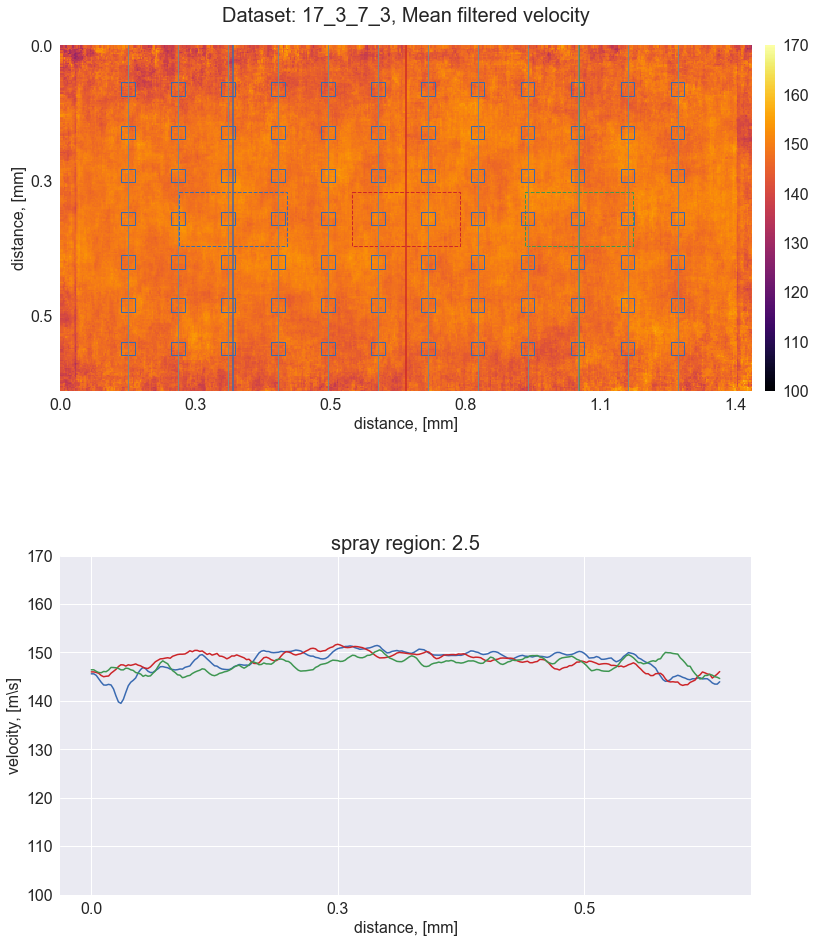

In [123]:
plot_velocity_map = True
plot_profiles = True
plot_time_evolution = False

amp, corr, amp_filtered = make_analysis_figure()

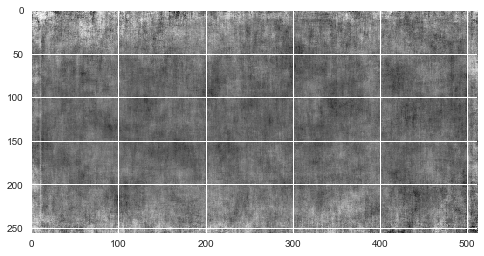

149.9059

In [127]:
amp_filtered = np.array(Image.open(results_path +'_amp_mean_filter.tif'))

plt.imshow(amp_filtered)
plt.show()

amp_filtered[125,125]

In [118]:
pd.set_option('display.width', 1000)

# Patch size for measurement
px = 5
py = 5

step_in_mm = 0.1
step_in_pixels = int(step_in_mm * 1000 / pixel_size)
    
n = 5

vert_values = ['y:{0:.1f}mm'.format(x*step_in_pixels*pixel_size /1000) for x in np.arange(-(n-1)/2, (n-1)/2+1)]
columns = ['Dataset', 'Tile', 'Dist'] + vert_values
df = pd.DataFrame(columns=columns )


In [114]:
summarize_velocity_profiles(amp_filtered, df, 5)

df

Offset: 100


,Dataset,Tile,Dist,y:-0.2mm,y:-0.1mm,y:0.0mm,y:0.1mm,y:0.2mm
0,17_3_7_3,0,0.0,146.4,147.4,149.6,148.3,151.3
1,17_3_7_3,0,0.1,147.5,150.2,149.6,149.8,146.9
2,17_3_7_3,0,0.2,146.6,148.6,148.0,150.6,147.3
3,17_3_7_3,0,0.3,145.5,151.8,149.6,148.8,145.0
4,17_3_7_3,0,0.4,148.5,149.4,149.7,148.0,148.4
5,17_3_7_3,0,0.5,148.9,149.5,150.4,147.3,148.1
6,17_3_7_3,0,0.6,148.5,147.6,149.5,150.0,147.9
7,17_3_7_3,0,0.7,148.7,150.6,149.9,147.6,146.2
8,17_3_7_3,0,0.8,146.3,148.4,149.5,148.0,147.1
9,17_3_7_3,0,0.9,146.9,149.9,151.8,149.7,150.8


## Testing

In [97]:
def test_averaging_methods_correlation(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 512
    height = 256
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    min_vel_in_pixels = 0
    max_vel_in_pixels = 20
    
    filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
    amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
    im_res = Image.fromarray(amp_filtered_mean*vel_factor)
    im_res.save(results_path + 'test_amp_mean_filter.tif')
    
    print(np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    
    c_list = np.arange(0, 0.4, 0.02)
    res = []
    
    for c in tqdm(c_list):
            
        filtered_corr = np.where(corr > c, 1, 0)
        filtered_amp2 = filtered_amp*filtered_corr
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp2)

        #im_res = Image.fromarray(amp_filtered_mean*vel_factor)
        #im_res.save(results_path + 'test_amp_mean_filter_corr.tif')

        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)
        
        res.append(mean_vel_in_center)
        
        #print(mean_vel_in_center)
    
    plt.plot(c_list, res)
    plt.title('No magnitude filtering, Minimal valid correlation')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Velocity, m/s')
    plt.show()
    
    print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

In [15]:
def test_averaging_methods_min_max(): 
    
    #------------------------------------------------
    # Filtering according to physical contraints
    #------------------------------------------------
    
    width = 512
    height = 256
    
    cx = int(width / 2) 
    cy = int(height / 2)
    
    amp_mean = np.mean(images, axis=0)
    print('Mean unfiltered:', np.mean(amp_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    amp_median = np.median(images, axis=0)
    print('Median unfiltered:', np.mean(amp_median[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor))
    
    
    filtered_corr = np.where(corr > min_corr_value, 1, 0)
    
    m = 145
    
    perc = np.arange(0.1, 0.7, 0.05)
    #perc = np.array([0.1, 0.25, 0.5])
    
    res = []
    
    for p in tqdm(perc):

        min_vel_in_pixels = (1.0 - p)*amp_mean
        max_vel_in_pixels = (1.0 + p)*amp_mean

        filtered_amp = np.where(np.all([images > min_vel_in_pixels, images < max_vel_in_pixels], axis=0), images, 0)
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
        filtered_amp2 = filtered_amp*filtered_corr
        amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp2)
        mean_vel_in_center = np.mean(amp_filtered_mean[cy-ry:cy+ry,cx-rx:cx+rx]*vel_factor)

        res.append(mean_vel_in_center)
    
    return res
    
    #print(res)
    #data_amp = amp_filtered_mean*vel_factor
    
    #plt.hist(data_amp.flatten())
    #plt.show()

149.3453


100%|██████████████████████████████████████████| 20/20 [00:32<00:00,  1.57s/it]


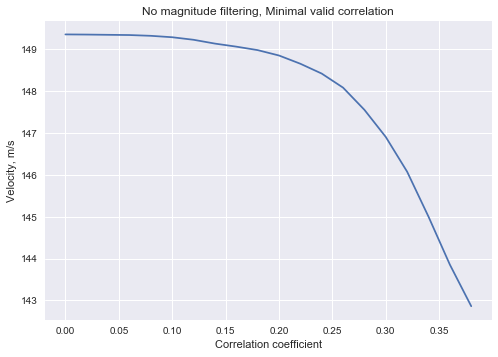

[149.34531688256496, 149.34159949300073, 149.3357622138925, 149.3302163632521, 149.31182891803425, 149.27787434810645, 149.2172930979458, 149.12638311374607, 149.05360625642612, 148.9708500772774, 148.84217835175147, 148.64574005403068, 148.41124071310085, 148.07571998454364, 147.54642078644903, 146.8991234190778, 146.07041159656583, 144.9986567673156, 143.85480930057173, 142.86375922040668]


In [98]:
test_averaging_methods_correlation()



In [16]:
res = test_averaging_methods_min_max()

Mean unfiltered: 149.28888
Median unfiltered: 153.31612


100%|██████████████████████████████████████████| 12/12 [00:40<00:00,  3.42s/it]


[147.96780582630748, 150.35078816098567, 149.37770785865234, 149.49707885564223, 149.17868484383533, 149.17449526465995, 149.10311928898145, 149.10429380845525, 149.03417889962648, 149.02696998247683, 148.98032957692035, 148.98163440793704]


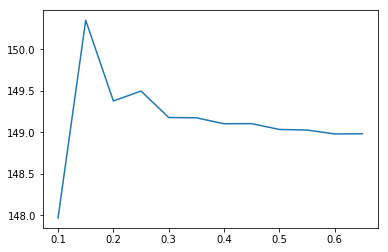

In [18]:
print(res)

perc = np.arange(0.1, 0.7, 0.05)

plt.plot(perc, res)
plt.show()

In [89]:
# Shift for 1mm in pixels

In [136]:
real = 1000 / 387
print('Estimated pixel size:',real)

Estimated pixel size: 2.5839793281653747


In [137]:
print('Difference estimated/theoretical:', real / 2.7)


Difference estimated/theoretical: 0.9570293808019905


In [139]:
145 * 0.95

137.75

In [40]:
1025 * pixel_size

2767.5

In [51]:
2306 - 2240

66

In [43]:
start_indexes = np.arange(66,3300, 220)
end_indexes   = start_indexes + 80

In [44]:
print(start_indexes)
print(end_indexes)

[  66  286  506  726  946 1166 1386 1606 1826 2046 2266 2486 2706 2926
 3146]
[ 146  366  586  806 1026 1246 1466 1686 1906 2126 2346 2566 2786 3006
 3226]


In [49]:
s = np.array([66, 290, 514, 738, 962, 1186, 1410, 1634, 1858, 2082, 2307])
e = np.array([160, 383, 607, 831, 1056, 1280, 1503, 1727, 1951, 2175, 2400])

print('Start dist:', s[1:] - s[:-1])
print('End dist:', e[1:] - e[:-1])

Start dist: [224 224 224 224 224 224 224 224 224 225]
End dist: [223 224 224 225 224 223 224 224 224 225]


In [50]:
print('Duration:', e - s)

Duration: [94 93 93 93 94 94 93 93 93 93 93]


In [56]:
print(s.tolist().index(290))

1


In [25]:
2.7 * 1024 / 1000 / 0.1

27.648

In [26]:
0.1 * 2.7 * 1000

270.0

In [27]:
100 / 2.7

37.03703703703704

In [107]:
image_width = 1024*pixel_size / 1000 # in mm
shift = 2.5 # in mm

offset = (image_width - shift) * 1000 / pixel_size # in pixels
offset

98.07407407407412